# TLdetect

An implementation of a convolutional neural network to detect the state of traffic lights in images. The states are red, green, yellow and no traffic light. Using the **tensorflow** framework.

### Importing packages

In [1]:
from PIL import Image
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import random
import src.data_processing as data

## Defining global parameters

In [2]:
NUM_ITERATIONS = 4
BATCH_SIZE = 64
KERNEL_SIZE = (3, 3)

### Pre-processing

Loading the images and labels and treating the dataset to fit better on our model. Note that the images won't be loaded right now, only their file names, in order to save memory and avoid bottlenecks and errors.

In [3]:
# Loading the labels
# At this moment, the conv net will only classify if an image has or not a traffic light.
labels = data.load_labels()
print("Number of labels loaded: %d" % len(labels))

Number of labels loaded: 13063


In [4]:
# Loading the images. In reality, just their names
images = labels['file']
X_train, X_val, X_test = data.split_dataset(images)

# Debug
print("Data set of %d images split in 3 sets.\n" % len(images))
print("Train: {}".format(X_train.shape))
print("Validation: {}".format(X_val.shape))
print("Test: {}".format(X_test.shape))

Data set of 13063 images split in 3 sets.

Train: (9438,)
Validation: (1665,)
Test: (1960,)


In [5]:
# Spliting the labels
y_train = data.extract_labels(labels, X_train)
y_val = data.extract_labels(labels, X_val)
y_test = data.extract_labels(labels, X_test)

# Debug
print("Lables extracted.\n")
print("Train labels shape: {}".format(y_train.shape))
print("Train validation shape: {}".format(y_val.shape))
print("Train test shape: {}".format(y_test.shape))

Lables extracted.

Train labels shape: (9438,)
Train validation shape: (1665,)
Train test shape: (1960,)


### Creating the model

At the following cells we will define our model. Our model, at this moment, will just classify if a given image has a traffic light or not.

Note that the inputs pass through two max-pooling layers before starts to be recognized. This technique is used to reduce the dimensionality of the inputs.

The original inputs has the dimension of (1200, 1920, 3).

#### The following architecture will be used:
1. **Pooling layer**
+ **Pooling layer**
+ **Pooling layer**
+ **Convolutional layer w/ 64 filters**
+ **Convolutional layer w/ 32 filters**
+ **Pooling layer**
+ **Convolutional layer w/ 32 filter**
+ **Convolutional layer w/ 32 filter**
+ **Convolutional layer w/ 16 filter**
+ **Pooling layer**
+ **512 Fully connected units with Dropout**
+ **10 Fully connected units**
+ **Classification**

## Defining the architecture

In [6]:
from tensorflow.contrib.keras import layers, models, backend, optimizers

model = models.Sequential()
model.add(layers.MaxPool2D(pool_size=2, strides=2,
                           data_format='channels_last',
                           input_shape=(1200, 1920, 3)
                          ))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.MaxPool2D(pool_size=2, strides=2))

model.add(layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, strides=1,
                        padding='same',
                        activation='relu'
                       ))
model.add(layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, strides=1,
                        padding='same',
                        activation='relu'
                       ))

model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, strides=1,
                        padding='same',
                        activation='relu'
                       ))
model.add(layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, strides=1,
                        padding='same',
                        activation='relu'
                       ))
model.add(layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, strides=1,
                        padding='same',
                        activation='relu'
                       ))
model.add(layers.MaxPool2D(pool_size=2, strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))


optim = optimizers.SGD(1e-5, momentum=0.9)
model.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 600, 960, 3)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 300, 480, 3)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 240, 3)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 120, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 120, 64)       1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 120, 32)       18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 60, 32)        0         
__________

## Training the model

#### Defining a checkpoint

In [7]:
from tensorflow.contrib.keras import callbacks
filepath = 'models/tldetect_bin_classification_model'
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='loss',
                                       verbose=1,
                                       save_best_only=True)

#### Training

In [8]:
report = model.fit_generator(data.images_generator(X_train, y_train, BATCH_SIZE),
                    int(X_train.shape[0]/BATCH_SIZE),
                    epochs=NUM_ITERATIONS,
                    callbacks=[checkpoint]
                   )

Epoch 1/4
147/147 [==============================] - 709s - loss: 1.0578 - acc: 0.5657   
Epoch 2/4
147/147 [==============================] - 710s - loss: 0.7076 - acc: 0.6009   
Epoch 3/4
147/147 [==============================] - 715s - loss: 0.6931 - acc: 0.6089   
Epoch 4/4
147/147 [==============================] - 712s - loss: 0.6790 - acc: 0.6115   


#### Plotting the training report

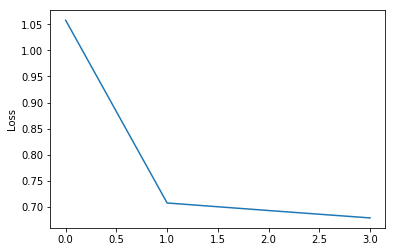

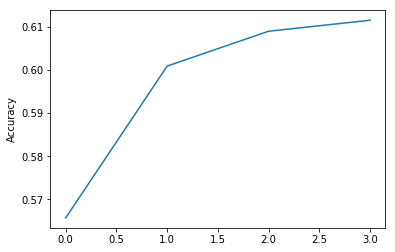

In [9]:
plt.plot(report.history['loss'])
plt.ylabel('Loss')
plt.show()

plt.plot(report.history['acc'])
plt.ylabel('Accuracy')
plt.show()